In [1]:
%load_ext autoreload
%autoreload 2
from test_tube import HyperOptArgumentParser
import pytorch_lightning as pl
from argparse import Namespace
import socket
from gfbm.train_encoder_BF import train_encoder
from gfbm.cluster.init_clusters import get_cluster_object
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinvh
import warnings
from glob import glob
import os

In [2]:
def fbm_covar(L, alpha, sigma):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        C = np.fromfunction(lambda i,j : np.exp(alpha*np.log(np.abs(i - j))), (L,L),dtype=np.float64)
        np.fill_diagonal(C,0.)
        B = np.fromfunction(lambda i,j : np.exp(alpha*np.log(np.abs(i))), (L,L),dtype=np.float64)
        A = np.fromfunction(lambda i,j : np.exp(alpha*np.log(np.abs(j))), (L,L),dtype=np.float64)
        S = np.copy(0.5*(A+B-C))
        S = S[1:]
        S = S[:,1:]
        np.fill_diagonal(S,np.diagonal(S) + sigma**2)

        C = np.fromfunction(lambda i,j : np.log(np.abs(i-j))*np.exp(alpha*np.log(np.abs(i - j))), (L,L),dtype=np.float64)
        np.fill_diagonal(C,0.)
        B = np.fromfunction(lambda i,j : np.log(np.abs(i))*np.exp(alpha*np.log(np.abs(i))), (L,L),dtype=np.float64)
        A = np.fromfunction(lambda i,j : np.log(np.abs(j))*np.exp(alpha*np.log(np.abs(j))), (L,L),dtype=np.float64)
        d_S = np.copy(0.5*(A+B-C))
        d_S = d_S[1:]
        d_S = d_S[:,1:]
    
    S_inv = pinvh(S)
    
    return S, d_S, S_inv

In [3]:
def min_variance(d_C, C_inv):
    I = 0.5*np.trace(C_inv @ d_C @ C_inv @ d_C)
    return 1. / I

In [13]:
alpha_values = [.8,.9,1.,1.1,1.2] #np.linspace(0.6,1.4,30,endpoint=True)
sigma_values = np.linspace(0.,5.,50,endpoint=True)
L = 200
min_v = {}
for alpha in alpha_values:
    for sigma in sigma_values:
        S, d_S, S_inv = fbm_covar(L=L, alpha=alpha, sigma=sigma)
        min_v[(alpha,sigma)] = min_variance(d_S, S_inv)

In [14]:
mean_cramer_rao = [np.mean([min_v[(a,sigma)] for a in alpha_values]) for sigma in sigma_values]

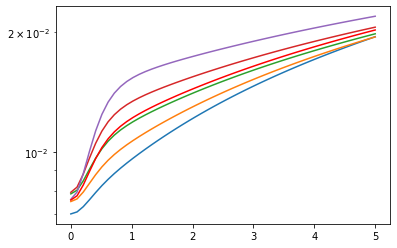

In [15]:
for alpha in alpha_values:
    plt.plot(sigma_values,[min_v[(alpha,s)] for s in sigma_values])
plt.plot(sigma_values, mean_cramer_rao,c="red")
plt.yscale("log")

# Load models trained with noise

In [7]:
from gfbm.layers.BFlow import BFlowEncoder
from gfbm.data_tools.datamodule import DataModule

In [20]:
l = glob("%s/models/noise_4/BF_alpha_*_*noise*" % os.environ["WORK"])

In [21]:
l

['/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_5.00_ea9c_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_0.00_db9e_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_2.00_4af6_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_3.00_52a0_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_0.75_619d_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_0.50_252b_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_0.25_0c4a_noise_4_200.ckpt',
 '/gpfswork/rech/vjk/uxo83vo/models/noise_4/BF_alpha_encoder_L200_bs128_LR_1.0e-04_AD_noise_1.00_23c7_noise_4_200.ckpt']

In [22]:
L = 200
dl_params = {
    "batch_size": 128,
    "num_workers": 4,
}

mse = {}
var = {}
for m in l:
    
    model = BFlowEncoder.load_from_checkpoint(m)
    model.eval()
    model.freeze()
    model.to("cuda")

    noise = model.hparams["noise_sigma"]
    
    mse[noise] = []
    var[noise] = []
    
    for i, alpha in enumerate(alpha_values):
        

        dm = DataModule(dl_params=dl_params,
            ds_params={"N": int(3e3),
                       "dim": model.hparams["dim"],
                       "length_range": model.hparams["length_range"],
                       "vary_tau": False,
                       "alpha_range": (alpha, alpha),
                       "noise": noise},
            graph_info={"edge_method": "geom_causal",
                        "degree": model.hparams["degree"]},
            no_parallel=True)

        dl_test = dm.test_dataloader(no_parallel=True)

        outs_ = []
        true_ = []
        for batch in dl_test:
            output, trajs = model(batch.to(model.device))
            outs_.append(output.cpu())
            true_.append(trajs.alpha.cpu())

        output = np.concatenate(outs_,axis=0)
        alpha = np.concatenate(true_,axis=0)

        #plt.figure()
        #plt.scatter(alpha, output,s=.5)
        #plt.title("Sigma = %.2f" % noise)
        #plt.tight_layout()

        mse[noise].append(np.mean((output-alpha)**2))
        var[noise].append(np.var(output))

f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
seed_offset = 3000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Inp

In [23]:
sorted(mse)

[0.0, 0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0]

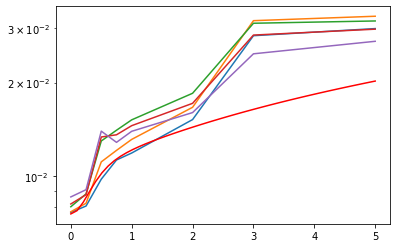

In [26]:
for i, alpha in enumerate(alpha_values):
    plt.plot(sorted(mse), [mse[n][i] for n in sorted(mse)])
plt.plot(sigma_values, mean_cramer_rao,c="red")
plt.yscale("log")

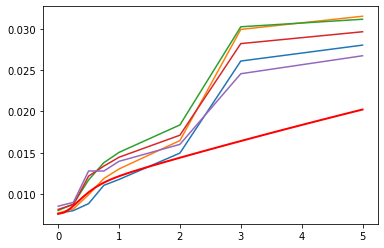

In [25]:
for i, alpha in enumerate(alpha_values):
    plt.plot(sorted(mse), [var[n][i] for n in sorted(var)])
plt.plot(sigma_values, mean_cramer_rao,c="red",lw=2)

In [27]:
L = 200
dl_params = {
    "batch_size": 128,
    "num_workers": 4,
}

mse = {}
var = {}
for m in l:
    
    model = BFlowEncoder.load_from_checkpoint(m)
    model.eval()
    model.freeze()
    model.to("cuda")

    noise = model.hparams["noise_sigma"]
    
    mse[noise] = []
    var[noise] = []
    
    dm = DataModule(dl_params=dl_params,
        ds_params={"N": int(1e4),
                   "dim": model.hparams["dim"],
                   "length_range": model.hparams["length_range"],
                   "vary_tau": False,
                   "alpha_range": (0.6,1.4),
                   "noise": noise},
        graph_info={"edge_method": "geom_causal",
                    "degree": model.hparams["degree"]},
        no_parallel=True)

    dl_test = dm.test_dataloader(no_parallel=True)

    outs_ = []
    true_ = []
    for batch in dl_test:
        output, trajs = model(batch.to(model.device))
        outs_.append(output.cpu())
        true_.append(trajs.alpha.cpu())

    output = np.concatenate(outs_,axis=0)
    alpha = np.concatenate(true_,axis=0)

    #plt.figure()
    #plt.scatter(alpha, output,s=.5)
    #plt.title("Sigma = %.2f" % noise)
    #plt.tight_layout()

    mse[noise] = np.mean((output-alpha)**2)
    var[noise] = np.var(output)

f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/pytorch-gpu-1.8.0/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000
f size =  [64, 128, 64, 32]
Convolution has 19296 parameters. Input dim is 32, output is 32
seed_offset = 10000


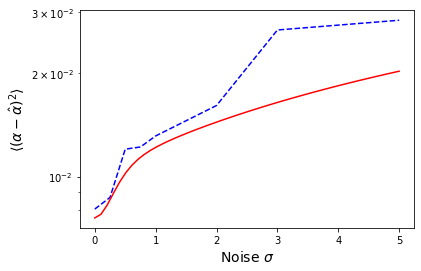

In [34]:
plt.plot(sorted(mse), [mse[n] for n in sorted(mse)],c="blue",ls="--")
plt.plot(sigma_values, mean_cramer_rao,c="red")
plt.yscale("log")
plt.xlabel("Noise $\\sigma$",fontsize=14)
plt.ylabel("$\\langle (\\alpha - \hat{\\alpha})^2 \\rangle$",fontsize=14)
plt.savefig("%s/paper-fbm/figure_noise.pdf" % os.environ["SCRATCH"])